In [2]:
from astropy import units as u
from astropy import time

import numpy as np

from poliastro import iod
from poliastro.bodies import Mars, Earth, Jupiter, Sun
from poliastro.ephem import Ephem
from poliastro.maneuver import Maneuver
from poliastro.twobody import Orbit
from poliastro.util import time_range
from poliastro.plotting import OrbitPlotter3D, StaticOrbitPlotter
import math
import matplotlib.pyplot as plt
# More info: https://plotly.com/python/renderers/
import plotly.io as pio

pio.renderers.default = "plotly_mimetype+notebook_connected"

from astropy.coordinates import solar_system_ephemeris


solar_system_ephemeris.set("jpl")

c:\Users\jacki\miniforge-pypy3\envs\python_3.9\lib\site-packages\poliastro\core\_jit.py:29: UserWarning: Could not import numba package. All poliastro functions will work properly but the CPU intensive algorithms will be slow. Consider installing numba to boost performance.
  warnings.warn(


<ScienceState solar_system_ephemeris: 'jpl'>

In [3]:
#starship specs
isp = 380
dry_mass = 100
prop_mass = 1200 #tons
lmo_fuel = 250


landing_reserve = 500

starship_dv = isp*9.81*math.log((dry_mass+prop_mass)/dry_mass)
boiloff = 0#0 

#for a skimpy 100t starship, only need 20 tons of landing fuel
print(isp*9.81*math.log((120)/(100)))



679.658299416504


c:\Users\jacki\miniforge-pypy3\envs\python_3.9\lib\site-packages\erfa\core.py:133: ErfaWarning:

ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"

c:\Users\jacki\miniforge-pypy3\envs\python_3.9\lib\site-packages\erfa\core.py:133: ErfaWarning:

ERFA function "utctai" yielded 1 of "dubious year (Note 3)"

c:\Users\jacki\miniforge-pypy3\envs\python_3.9\lib\site-packages\erfa\core.py:133: ErfaWarning:

ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"



Ejection is with 8961m/s of DV (in sun reference frame, so actual number is different)
departure from Earth (♁) on 2035-07-20 00:02:09.185
arrival at Jupiter (♃) on 2037-09-27 00:02:09.185


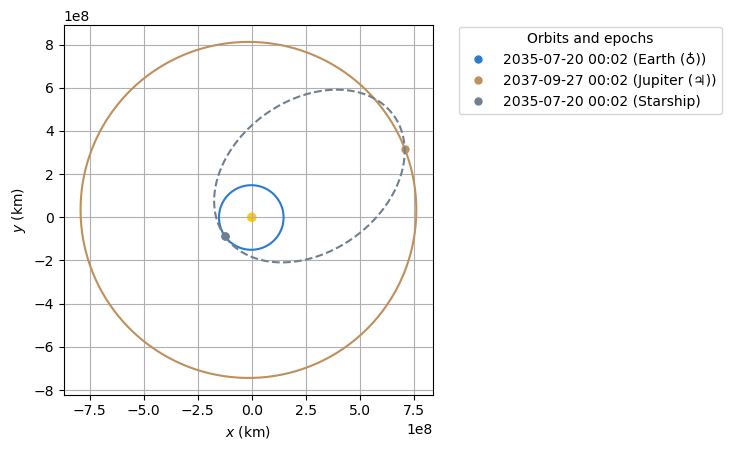

In [4]:

#launch from body_1 to body_2
body_1 = Earth
body_2 = Jupiter


#starship specs
isp = 380
dry_mass = 70#stripped down  expendable
#dry_mass = 120#resuable cargo
#dry_mass = 163#crew
prop_mass = 1500


landing_reserve = 0


starship_dv = isp*9.81*math.log((dry_mass+prop_mass)/dry_mass)
boiloff = 0#0 




#solve for a minimum ejection DV given a time period
transitTime = 800*u.day
resolution = 10*u.day
start_date = time.Time("2031-06-01 00:01", scale="utc").tdb
end_date = time.Time("2040-07-01 00:01", scale="utc").tdb

ephem_1 = Ephem.from_body(body_1, time_range(start_date, end=end_date+transitTime))
ephem_2 = Ephem.from_body(body_2, time_range(start_date, end=end_date+transitTime))


delta_time = end_date-start_date
lowest_dv = 100000
lowest_date = 0
lowest_orb = 0
for i in range(int(delta_time/resolution)):
    date_launch = start_date+i*resolution
    date_arrival = start_date+transitTime+i*resolution
    # Solve for departure and target orbits
    ss_planet_1 = Orbit.from_ephem(Sun, ephem_1, date_launch)
    ss_planet_2 = Orbit.from_ephem(Sun, ephem_2, date_arrival)

    # Solve for the transfer maneuver
    man_lambert = Maneuver.lambert(ss_planet_1, ss_planet_2)
    ejection = man_lambert[0]
    dv = np.linalg.norm(ejection[1].value)
    if(dv<lowest_dv):
        lowest_dv=dv
        lowest_date = date_launch
        lowest_orb,final = ss_planet_1.apply_maneuver(man_lambert, intermediate=True)


reserve_dv = starship_dv-int(lowest_dv)-landing_reserve
#print(f"Starship DV is {starship_dv}m/s")   
print(f"Ejection is with {int((1-boiloff)*lowest_dv)}m/s of DV (in sun reference frame, so actual number is different)")
#print(f"Reserve DV (not accounting for boiloff) is {reserve_dv}m/s")
print(f"departure from {body_1} on {lowest_date}")
print(f"arrival at {body_2} on {lowest_date+transitTime}")
      
dM = 0*u.day

fig, ax = plt.subplots()

ax.grid(True)
#ax.set_title("2033 90 day trajectory")

# We can check new bodies positions
plotter = StaticOrbitPlotter(ax)
ss_leave_1 = Orbit.from_ephem(Sun, ephem_1, lowest_date)
ss_arrival_2 = Orbit.from_ephem(Sun, ephem_2, lowest_date+transitTime)

plotter.plot_body_orbit(body_1,  lowest_date+dM, label=body_1)

plotter.plot_body_orbit(body_2,  lowest_date+dM+transitTime, label=body_2)
label_str = lowest_date.datetime.strftime("%Y-%m-%d")


#plotter.plot(ss_leave_1, label=label_str)

plotter.plot(lowest_orb, color="slategrey", label="Starship")

In [5]:
#calculate total boiloff during trip
starship_albedo = 0.1
#approxing solar irradiance with tanh between body 1 and body 2
def sig_rad(dT):
    return (math.exp(dT)-math.exp(-dT))/(math.exp(dT)+math.exp(-dT))



In [6]:
#Find SOI change on departure
#for the optimized trajectory, re get the epherimis
date_launch = lowest_date
date_arrival = lowest_date+transitTime
#ss_earth = Orbit.from_ephem(Sun, earth, date_launch)

#arrival body is body 2
ss_body_1 = Orbit.from_ephem(Sun, ephem_1, date_launch)


#calculate SOI crossing point
ss_transfer = lowest_orb
ss_final = lowest_orb
time_sliver = 0.01*u.day
steps = int(((transitTime+3*u.day)/time_sliver).value)
print(f"{steps} steps")
soi_change_point = lowest_date+transitTime
for i in range(steps):
    ss_final = ss_transfer.propagate(i*time_sliver)
    arrival_distance = np.linalg.norm(ss_final.r-ss_body_1.r)
    #print(earth_distance)
    grav_difference = Sun.mass/(np.linalg.norm(ss_final.r)**2)-body_1.mass/((arrival_distance)**2)
    #print(grav_difference)
    if(grav_difference>0):
        print(f"Departure at step{i}")
        soi_change_point = date_launch+i*time_sliver
        break


print(f"Departed SOI on {soi_change_point}")



80300 steps
Departure at step9
Departed SOI on 2035-07-20 02:11:45.185


Soi change at 297464.11095243884 km (potentially seems low tbf)
C3 is 80.28810540056064 km2 / s2
Starship DV is 11594.709259529027m/s
Ejection velocity is 14.226938653583366 km / s
Ejection DV is 6.41292310291213 km / s
Starship has 5181.786156616898 m / s of DV after the burn excluding landing reserve (500 m/s)


c:\Users\jacki\miniforge-pypy3\envs\python_3.9\lib\site-packages\erfa\core.py:133: ErfaWarning:

ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"

c:\Users\jacki\miniforge-pypy3\envs\python_3.9\lib\site-packages\erfa\core.py:133: ErfaWarning:

ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"



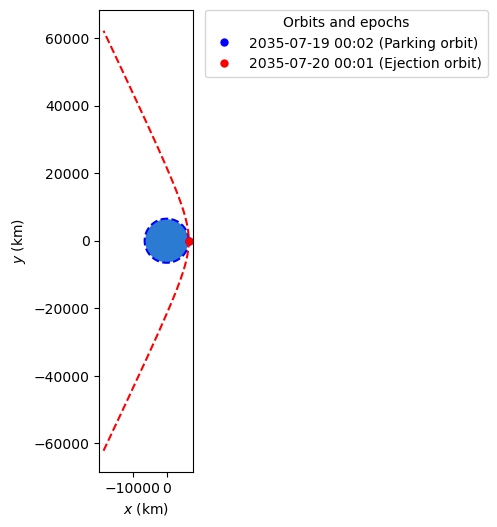

In [7]:
ss_final = lowest_orb.propagate(soi_change_point-date_launch) 


r_body_1, v_body_1 = ss_body_1.r,ss_body_1.v
r_sc_arriv = ss_final.r-r_body_1
v_sc_arriv = ss_final.v-v_body_1
c3_a = np.linalg.norm(v_sc_arriv)**2
print(f"Soi change at {np.linalg.norm(r_sc_arriv)} (potentially seems low tbf)")
print(f"C3 is {c3_a}")


#C3 only orbit calc
r_p = 150*u.km#parking orbit

parking_orbit = Orbit.circular(body_1,alt = r_p,epoch = date_launch-1*u.day)


a_exit = -(body_1.k / c3_a).to(u.km)
ecc_exit = 1 - (r_p+body_1.R) / a_exit

departure_orbit = Orbit.from_classical(
    body_1,
    a_exit,
    ecc_exit,
    0 * u.deg,
    0 * u.deg,
    0 * u.deg,
    0 * u.deg,  # We don't mind
    time.Time(date_launch, scale="utc"),
)
print(f"Starship DV is {starship_dv}m/s")   
print(f"Ejection velocity is {np.linalg.norm(departure_orbit.v)}")
print(f"Ejection DV is {np.linalg.norm(departure_orbit.v)-np.linalg.norm(parking_orbit.v)}")
ejection_dv = (np.linalg.norm(departure_orbit.v)-np.linalg.norm(parking_orbit.v)).value
reserve_dv = starship_dv-(ejection_dv*1000)-landing_reserve
print(f"Starship has {reserve_dv} m / s of DV after the burn excluding landing reserve (500 m/s)")

earth_plotter = StaticOrbitPlotter()

earth_plotter.plot(parking_orbit, label="Parking orbit", color="b")
earth_plotter.plot(departure_orbit, label="Ejection orbit", color="r")


In [8]:
#for the optimized trajectory, re get the epherimis
date_launch = lowest_date
date_arrival = lowest_date+transitTime
#ss_earth = Orbit.from_ephem(Sun, earth, date_launch)

#arrival body is body 2
ss_body_2 = Orbit.from_ephem(Sun, ephem_2, date_arrival)


#calculate SOI crossing point

ss_transfer = lowest_orb
ss_final = lowest_orb
time_sliver = 0.1*u.day
steps = int(((transitTime+3*u.day)/time_sliver).value)
print(f"{steps} steps")
soi_change_point = lowest_date+transitTime
for i in range(steps):
    ss_final = ss_transfer.propagate(i*time_sliver)
    arrival_distance = np.linalg.norm(ss_final.r-ss_body_2.r)
    #print(earth_distance)
    grav_difference = Sun.mass/(np.linalg.norm(ss_final.r)**2)-body_2.mass/((arrival_distance)**2)
    #print(grav_difference)
    if(grav_difference<0):
        print(f"arrival at step{i}")
        soi_change_point = date_launch+i*time_sliver
        break


print(f"Normal arrival would be {date_arrival}")
print(f"Actual arrival at {soi_change_point}")



8030 steps
arrival at step7669
Normal arrival would be 2037-09-27 00:02:09.185
Actual arrival at 2037-08-24 21:38:09.185


Soi change at 67439755.93208043 km (potentially seems low tbf)
C3 is 45.42783214501715 km2 / s2
Arrival speed (at periapsis) is 59.71279530840976 km / s


c:\Users\jacki\miniforge-pypy3\envs\python_3.9\lib\site-packages\erfa\core.py:133: ErfaWarning:

ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"

c:\Users\jacki\miniforge-pypy3\envs\python_3.9\lib\site-packages\erfa\core.py:133: ErfaWarning:

ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"

c:\Users\jacki\miniforge-pypy3\envs\python_3.9\lib\site-packages\erfa\core.py:133: ErfaWarning:

ERFA function "utctai" yielded 1 of "dubious year (Note 3)"

c:\Users\jacki\miniforge-pypy3\envs\python_3.9\lib\site-packages\erfa\core.py:133: ErfaWarning:

ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"



Solar escape velocity at orbit of Jupiter (♃) is 18.4904711441544 km / s
We are going at 4.847062806360907 km / s
Solar Periapsis is 53.175831912530704 Gm
Comparing to Solar radius 0.6957000000000001 Gm
Solar escape velocity at perigee is 70.6502449285109 km / s
We are going at 78.35731346545155 km / s
We are on an escape trajectory, thus hyperbolic excess velocity is 7.707068536940653 km / s
It would take approx 333.37383454163245 yr to get there
Keeping in mind it will take frm launch, Voyager 1 160.58343695219216 yr to get there


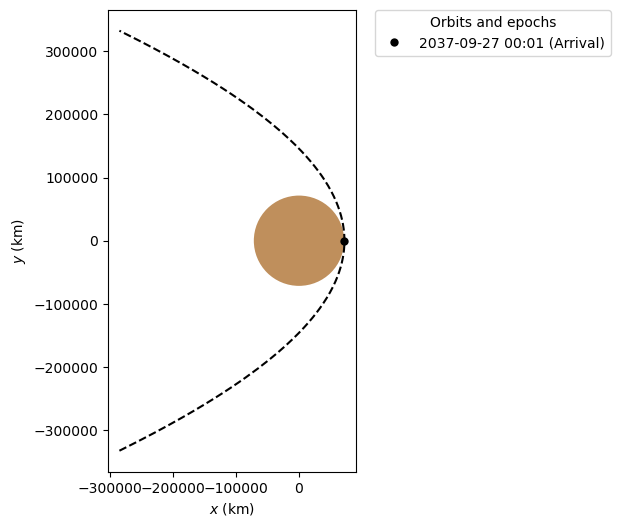

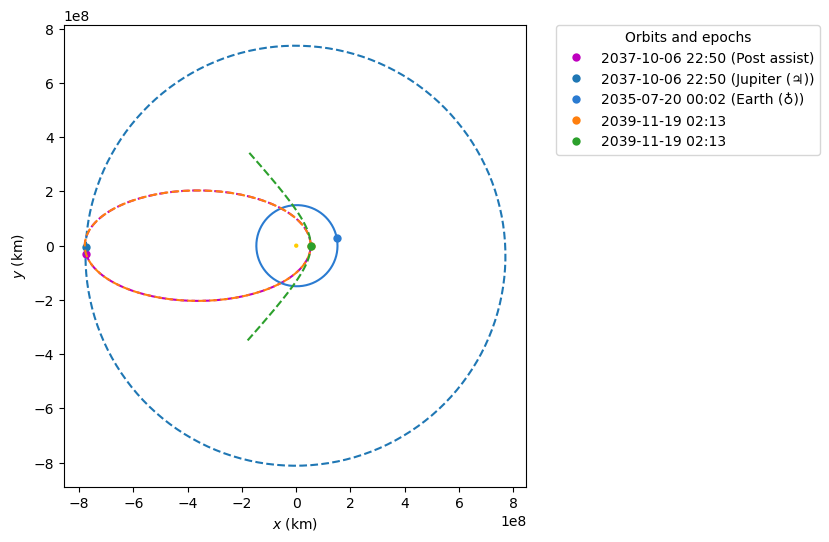

In [ ]:
#ITS BROKEN AND I UNDERSTAND WHY



buffer = 40*u.day #how long before entry interface to do the retro burn
ss_body_2 = Orbit.from_ephem(Sun, ephem_2, date_arrival+buffer)

ss_final = lowest_orb.propagate(soi_change_point-date_launch) 


r_body_2, v_body_2 = ss_body_2.r,ss_body_2.v
r_sc_arriv = ss_final.r-r_body_2
v_sc_arriv = ss_final.v-v_body_2
c3_a = np.linalg.norm(v_sc_arriv)**2
print(f"Soi change at {np.linalg.norm(r_sc_arriv)} (potentially seems low tbf)")
print(f"C3 is {c3_a}")


#C3 only orbit calc
r_p = 500*u.km#arrival periapsis
a_exit = -(body_2.k / c3_a).to(u.km)
ecc_exit = 1 - (r_p+body_2.R) / a_exit
intra_inc = 0.1*u.deg


arrival_orbit = Orbit.from_classical(
    body_2,
    a_exit,
    ecc_exit,
    inc = intra_inc,
    raan = 0 * u.deg,
    argp = 200 * u.deg,#I think shifting this should shift the outgoing orbit/direction of gravity assit
    nu=0 * u.deg,  # We don't mind
    epoch=time.Time(date_arrival, scale="utc"),
)

earth_plotter = StaticOrbitPlotter()

earth_plotter.plot(arrival_orbit, label="Arrival", color="k")

arrival_circular_orbit = Orbit.circular(body_2,alt = 200*u.km)

print(f"Arrival speed (at periapsis) is {np.linalg.norm(arrival_orbit.v)}")

#propogate orbit to SOI change on the way out
step = 0.05*u.day
steps = 10*u.day/step
prop_orb = arrival_orbit.propagate(step)

for i in range(int(steps.value)):
    prop_orb = prop_orb.propagate(step)
    sun_distance = np.linalg.norm(prop_orb.r+ss_body_2.r)
    #print(earth_distance)
    grav_difference = Sun.mass/(sun_distance**2)-body_2.mass/(np.linalg.norm(prop_orb.r)**2)
    #print(grav_difference)
    if(grav_difference>0):
        print(f"left SOI of {body_2} on step {i} which is {date_arrival+i*step}")
        soi_change_point = date_launch+i*time_sliver
        break

#calcualte new orbit aorund SUN
post_assist_epoch = date_arrival+i*step
n_sun_r = prop_orb.r+ss_body_2.r
n_sun_v = prop_orb.v+ss_body_2.v
post_assist_orbit = Orbit.from_vectors(Sun,n_sun_r,n_sun_v,epoch = post_assist_epoch)

sun_plt = StaticOrbitPlotter()
body_2_orb =  Orbit.from_ephem(Sun,ephem = ephem_2,epoch = post_assist_epoch)
escape_vel = ((2*Sun.k/np.linalg.norm(body_2_orb.r))**0.5).to(u.km/u.s)
print(f"Solar escape velocity at orbit of {body_2} is {escape_vel}")
print(f"We are going at {np.linalg.norm(n_sun_v)}")

target = 542*u.au
hyperbol_excess = np.linalg.norm(n_sun_v)-escape_vel

if(hyperbol_excess>0):
    print(f"We are on an escape trajectory, thus hyperbolic excess velocity is {hyperbol_excess}")
    print(f"It would take approx {(target.to(u.km)/hyperbol_excess).to(u.year)} to get there")
else:
    print(f"Solar Periapsis is {post_assist_orbit.r_p.to(u.Gm)}")
    print(f"Comparing to Solar radius {Sun.R.to(u.Gm)}")

sun_plt.plot(post_assist_orbit, label="Post assist", color="m")
sun_plt.plot(body_2_orb, label=body_2)
sun_plt.plot_body_orbit(body_1,  lowest_date+dM, label=body_1)

#Then propagate that orbit to solar periapsis and burn 
sol_peri = post_assist_orbit.propagate(-post_assist_orbit.t_p)
sun_plt.plot(sol_peri)

prograde_vector = (sol_peri.v/(np.linalg.norm(sol_peri.v))).value
burn_dv = 10#km/s




burn = Maneuver((0*u.s,burn_dv*prograde_vector*u.km/u.s))
escape = sol_peri.apply_maneuver(burn)
sun_plt.plot(escape)
escape_vel = ((2*Sun.k/np.linalg.norm(sol_peri.r))**0.5).to(u.km/u.s)
print(f"Solar escape velocity at perigee is {escape_vel}")
print(f"We are going at {np.linalg.norm(escape.v)}")
hyperbol_excess = np.linalg.norm(escape.v)-escape_vel
c_3 = 

if(hyperbol_excess>0):
    print(f"We are on an escape trajectory, thus hyperbolic excess velocity is {hyperbol_excess}")
    print(f"It would take approx {(target.to(u.km)/hyperbol_excess).to(u.year)} to get there")
    print(f"Keeping in mind it will take frm launch, Voyager 1 {((target.to(u.km))/(16*u.km/u.s)).to(u.year)} to get there")

In [19]:
#for the optimized trajectory, re get the epherimis
date_launch = lowest_date
date_arrival = lowest_date+transitTime
ss_earth = Orbit.from_ephem(Sun, earth, date_launch)
ss_mars = Orbit.from_ephem(Sun, mars, date_arrival)




#ejection from Earth
#calculate departure orbit
prop_time = 0.012*u.day

ss_leave = lowest_orb.propagate(prop_time)
r_earth,v_earth=ss_earth.r,ss_earth.v
r_traj_leave = ss_leave.r-r_earth
v_traj_leave = ss_leave.v-v_earth


ejection_orbit = Orbit.from_vectors(Earth,r_traj_leave,v_traj_leave,epoch = date_launch)
#ejection_orbit.inc = 0*u.rad
#propogate ejection_orbit to periapsis



parking_orbit = Orbit.circular(Earth,inc=0*u.rad, alt=300 << u.km,epoch = date_launch)



print(ejection_orbit.energy)# = 0*u.rad
print(parking_orbit.energy)

#calculate ejection DV
#print(parking_orbit.v)
dE = ejection_orbit.energy-parking_orbit.energy
dV=np.sqrt(dE)
print(f"Ejection DV is {dV}")


print(parking_orbit)
print(ejection_orbit)
earth_ejection_plotter = StaticOrbitPlotter()

ejection_orbit.inc = 0*u.rad
earth_ejection_plotter.plot(parking_orbit, label="Parking Orbit", color="b")
earth_ejection_plotter.plot(ejection_orbit, label="Ejection Orbit", color="k")

NameError: name 'earth' is not defined